In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def loadFile(path, headers=None):
    '''
    This function will parse a standard HEKA .asc file into a pandas dataframe.

    Arguments:
    path - a stringIO input of a standard HEKA output .asc file.

    Returns:
    df, dfcache - two copies of the file reformatted into a dataframe.
    '''
    lineIndices = []            
   
    # Splits string at \n and removes trailing spaces  
    with open(path, "r") as f:                        
        rawFile = f.read().strip().split("\n")        

    count=0
    # Finds rows that contain header information to exclude from df                                    
    for line in rawFile:                                  
        if re.search(r"[a-z]+", line) == None:          
            lineIndices.append(count)                    
        count += 1                                    
   
    # Formats headerless file for later df
    processedFile = [rawFile[i].strip().replace(" ", "").split(",") for i in lineIndices]    

    # Use the difference in file size with and without headers to find nSweeps

    if headers == None:
         df = pd.DataFrame(data=processedFile)
    else:
        df = pd.DataFrame(columns=headers, data=processedFile)
    df = df.apply(pd.to_numeric)
    df = df.dropna(axis=0)
   
    nSweeps = df['index'].tolist().count(0)

    # Make new column with sweep identity
    df['sweep'] = np.repeat(np.arange(nSweeps) + 1, len(df)/(df['index'].tolist().count(1)))
    return df.reset_index(drop=True)

In [65]:
df = loadFile("20220128_N2A_pkg_cmv_mp1.asc", ["index", "ti", "i", "tv", "v", "tp", "p"])
df.i *= 1e12

## Subset
dfsub = df.query("@df.ti >= 5.0 & @df.ti <= 5.8")
gdfsub = dfsub.groupby("sweep")

## Find peak current
maxindex = gdfsub["i"].max()
peaks = df.query("@df.i in @maxindex")

## Find steady state
dfss = df.query("@df.ti <= 5.4 & @df.ti >= 5.3")
ss = dfss.groupby("sweep")["i"].mean()

## Find mean peak and ss
meanss = np.mean(ss)
meanpeaks = np.mean(peaks.i)


In [66]:
##Call variables

peaks
meanss

84.65367305053547

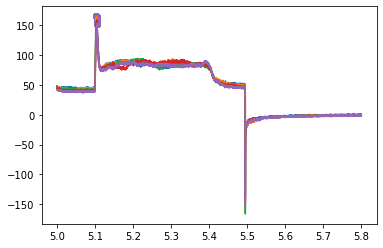

In [56]:
for k, g in gdfsub:
    plt.plot(g.ti, g.i)
    plt.scatter(peaks.ti, peaks.i, marker='o')

,index,ti,i,tv,v,tp,p
sweep,,,,,,,
1,58000.0,5.8,165.384317,5.800005,0.037807,5.800005,0.060075
2,58000.0,5.8,164.452049,5.800005,0.034682,5.800005,0.060075
3,58000.0,5.8,156.132995,5.800005,0.033433,5.800005,0.060075
4,58000.0,5.8,159.166374,5.800005,0.030933,5.800005,0.060075
5,58000.0,5.8,152.915056,5.800005,0.030620,5.800005,0.060075
